In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
import scipy.special as ssp
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import pytensor.tensor.extra_ops as ate
import corner

# Create True Q

$$
q \sim N_{[0,1]}(\mu=1, \sigma=0.15)
$$

In [2]:
from scipy.stats import truncnorm

mut = 1.0
sigmat = 0.15
N = 10000

at = (0.0 - mut) / sigmat
bt = (1.0 - mut) / sigmat

q_true = truncnorm.rvs(at, bt, loc=mut, scale=sigmat, size=N)

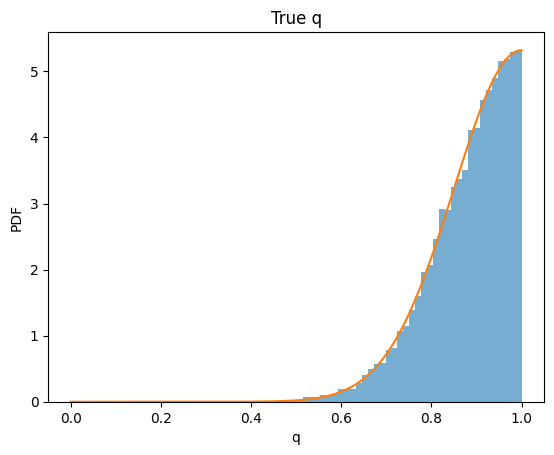

In [3]:
q_grid = np.linspace(0, 1, 500)
pdf = truncnorm.pdf(q_grid, at, bt, loc=mut, scale=sigmat)

plt.figure()
plt.hist(q_true, bins=50, density=True, alpha=0.6)
plt.plot(q_grid, pdf)
plt.xlabel("q")
plt.ylabel("PDF")
plt.title(r"True q")
plt.show()

# Inference with truth

$$
P(\mu, \sigma|\vec{q}_{true}) \propto \pi(\mu, \sigma) \prod_i^N N_{[0,1]}(q_{true}^i | \mu, \sigma)
$$

In [4]:
def make_model_true(q):
    q = np.asarray(q)
    with pm.Model() as model:        
        mu = pm.Uniform("mu", lower=0.0, upper=1.0)
        sigma = pm.Uniform("sigma", lower=0.1, upper=0.2)

        pm.TruncatedNormal("likelihood", mu=mu, sigma=sigma, lower=0.0, upper=1.0, observed=q)
    return model

In [5]:
with make_model_true(q_true) as model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


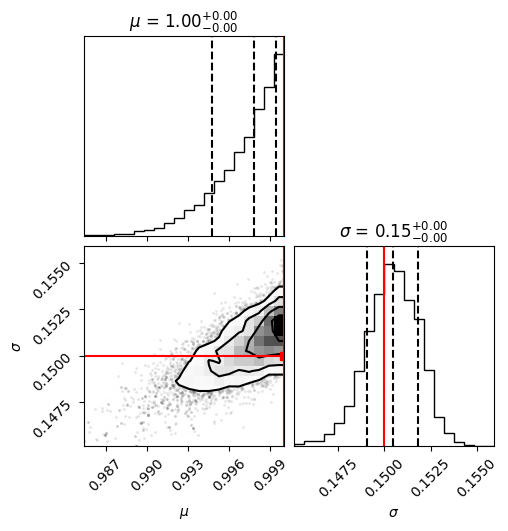

In [6]:
data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
true = np.array([mut, sigmat])
figure = corner.corner(
    data,
    labels=[
        r"$\mu$",
        r"$\sigma$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

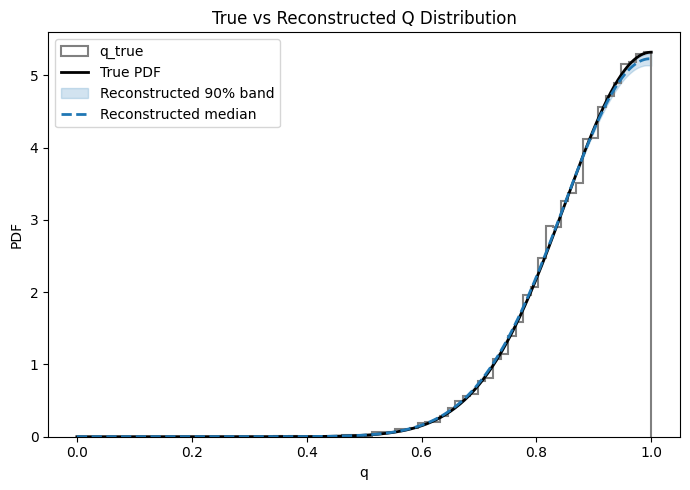

In [7]:
q_grid = np.linspace(0, 1, 500)

at = (0.0 - mut) / sigmat
bt = (1.0 - mut) / sigmat
pdf_true = truncnorm.pdf(q_grid, at, bt, loc=mut, scale=sigmat)

mu_samps = np.array(trace.posterior["mu"]).ravel()
sig_samps = np.array(trace.posterior["sigma"]).ravel()

max_draws = 5000
if mu_samps.size > max_draws:
    idx = np.random.choice(mu_samps.size, max_draws, replace=False)
    mu_samps = mu_samps[idx]
    sig_samps = sig_samps[idx]

a = (0.0 - mu_samps) / sig_samps
b = (1.0 - mu_samps) / sig_samps

pdf_draws = truncnorm.pdf(
    q_grid[None, :],
    a[:, None],
    b[:, None],
    loc=mu_samps[:, None],
    scale=sig_samps[:, None],
)

pdf_med = np.quantile(pdf_draws, 0.50, axis=0)
pdf_lo90 = np.quantile(pdf_draws, 0.05, axis=0)
pdf_hi90 = np.quantile(pdf_draws, 0.95, axis=0)


plt.figure(figsize=(7, 5))
plt.hist(q_true, bins=50, density=True, histtype="step", linewidth=1.5, color="0.5", label="q_true")
plt.plot(q_grid, pdf_true, color="k", lw=2, label="True PDF")

plt.fill_between(q_grid, pdf_lo90, pdf_hi90, color="C0", alpha=0.20, label="Reconstructed 90% band")

plt.plot(q_grid, pdf_med, color="C0", lw=2, linestyle="--", label="Reconstructed median")

plt.xlabel("q")
plt.ylabel("PDF")
plt.title("True vs Reconstructed Q Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# Create Observed Q

$$
q_{obs} \sim N(\mu=q_{true}, \sigma_{obs}=0.1)
$$

such that $q_{true} \in [0,1]$ and $q_{obs} \in \mathcal{R}$.

In [8]:
sigmao = 0.5

q_obs = np.random.normal(loc=q_true, scale=sigmao, size=len(q_true))

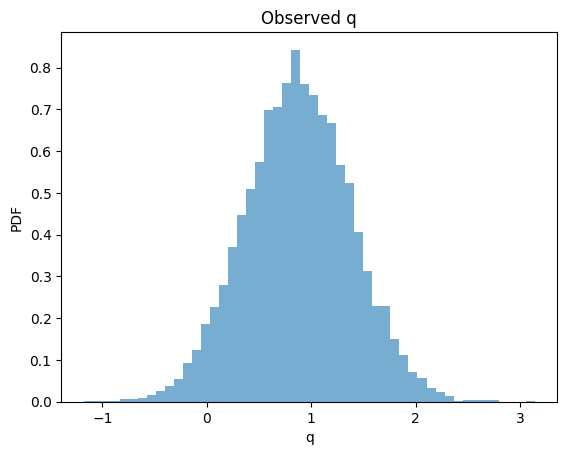

In [9]:
plt.hist(q_obs, bins=50, density=True, alpha=0.6)
plt.xlabel("q")
plt.ylabel("PDF")
plt.title(r"Observed q")
plt.show()

# Inference with observed

$$
P(\mu, \sigma|\vec{q}_{obs}) \propto \pi(\mu, \sigma) \prod_i^N \int_0^1 dq~N(q_{obs}^i | q, \sigma_{obs})~N_{[0,1]}(q | \mu, \sigma)
$$

$$
\propto \pi(\mu, \sigma) \prod_i^N \frac{N(q_{obs}^i | \mu, \sqrt{\sigma^2+\sigma_{obs}^2})}{\Phi\big(\frac{1-\mu}{\sigma}\big)-\Phi\big(-\frac{\mu}{\sigma}\big)}
$$

In [10]:
def make_model_obs(q, sigmao=sigmao):
    q = np.asarray(q)
    N = q.size

    with pm.Model() as model:
        mu = pm.Uniform("mu", lower=0.0, upper=1.0)
        sigma = pm.Uniform("sigma", lower=0.1, upper=0.2)

        sigma_eff = pm.math.sqrt(sigma**2 + sigmao**2)

        std_norm = pm.Normal.dist(0.0, 1.0)
        
        logZ = pm.math.logdiffexp(pm.logcdf(std_norm, (1.0 - mu) / sigma), pm.logcdf(std_norm, -mu / sigma))
        pm.Potential("potential", -N * logZ)

        pm.Normal("likelihood", mu=mu, sigma=sigma_eff, observed=q)
        
    return model

In [11]:
with make_model_obs(q_obs) as model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


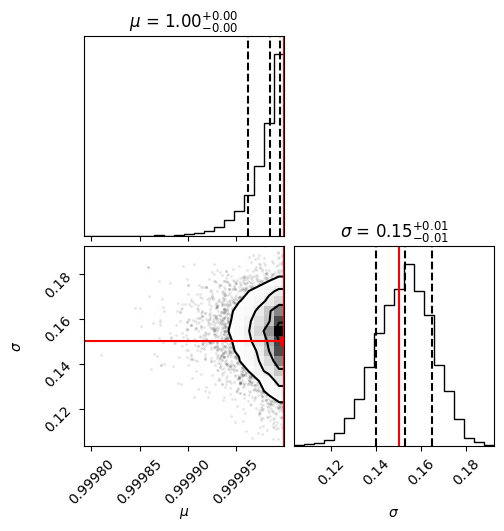

In [12]:
data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
true = np.array([mut, sigmat])
figure = corner.corner(
    data,
    labels=[
        r"$\mu$",
        r"$\sigma$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

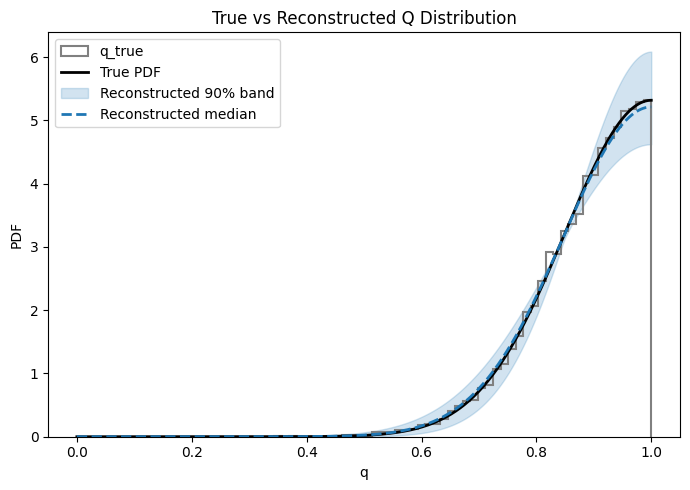

In [13]:
q_grid = np.linspace(0, 1, 500)

at = (0.0 - mut) / sigmat
bt = (1.0 - mut) / sigmat
pdf_true = truncnorm.pdf(q_grid, at, bt, loc=mut, scale=sigmat)

mu_samps = np.array(trace.posterior["mu"]).ravel()
sig_samps = np.array(trace.posterior["sigma"]).ravel()

max_draws = 5000
if mu_samps.size > max_draws:
    idx = np.random.choice(mu_samps.size, max_draws, replace=False)
    mu_samps = mu_samps[idx]
    sig_samps = sig_samps[idx]

a = (0.0 - mu_samps) / sig_samps
b = (1.0 - mu_samps) / sig_samps

pdf_draws = truncnorm.pdf(
    q_grid[None, :],
    a[:, None],
    b[:, None],
    loc=mu_samps[:, None],
    scale=sig_samps[:, None],
)

pdf_med = np.quantile(pdf_draws, 0.50, axis=0)
pdf_lo90 = np.quantile(pdf_draws, 0.05, axis=0)
pdf_hi90 = np.quantile(pdf_draws, 0.95, axis=0)


plt.figure(figsize=(7, 5))
plt.hist(q_true, bins=50, density=True, histtype="step", linewidth=1.5, color="0.5", label="q_true")
plt.plot(q_grid, pdf_true, color="k", lw=2, label="True PDF")

plt.fill_between(q_grid, pdf_lo90, pdf_hi90, color="C0", alpha=0.20, label="Reconstructed 90% band")

plt.plot(q_grid, pdf_med, color="C0", lw=2, linestyle="--", label="Reconstructed median")

plt.xlabel("q")
plt.ylabel("PDF")
plt.title("True vs Reconstructed Q Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# Inference with Observed (MCMC)
$$
P(\mu, \sigma|\vec{q}_{obs}) \propto \pi(\mu, \sigma) \prod_i^N \int_0^1 dq~N(q_{obs}^i | q, \sigma_{obs})~N_{[0,1]}(q | \mu, \sigma)
$$

$$
= \pi(\mu, \sigma) \prod_i^N \int_0^1 dq~N(q | q_{obs}^i, \sigma_{obs})~N_{[0,1]}(q | \mu, \sigma)
$$

$$
\propto \pi(\mu, \sigma) \prod_i^N \sum_{q \sim N(q | q_{obs}^i, \sigma_{obs}) \in [0,1]} N_{[0,1]}(q | \mu, \sigma)
$$

In [14]:
def make_model_obs_mc(q, sigmao=sigmao, M=200, seed=123):
    q = np.asarray(q, dtype=float)
    N = q.size
    rng = np.random.default_rng(seed)

    a = (0.0 - q) / sigmao
    b = (1.0 - q) / sigmao
    q_samps = truncnorm.rvs(a[:, None], b[:, None], loc=q[:, None], scale=sigmao, 
                            size=(N, M), random_state=rng).astype(float)

    with pm.Model() as model:
        
        mu = pm.Uniform("mu", lower=0.0, upper=1.0)
        sigma = pm.Uniform("sigma", lower=0.1, upper=0.2)

        Q = pm.Data("Q_mc", q_samps)

        std = pm.Normal.dist(0.0, 1.0)
        logZ = pm.math.logdiffexp(pm.logcdf(std, (1.0 - mu) / sigma), pm.logcdf(std, (-mu) / sigma))

        logp_q = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), Q) - logZ

        logLi = pm.logsumexp(logp_q, axis=1) - np.log(M)

        pm.Potential("likelihood", pt.sum(logLi))

    return model

In [15]:
with make_model_obs_mc(q_obs) as model:
    trace = pm.sample(tune=2000, draws=2000, target_accept=0.9, chains=4)

/home/soumendrakishore.roy/.conda/envs/Om/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3342 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


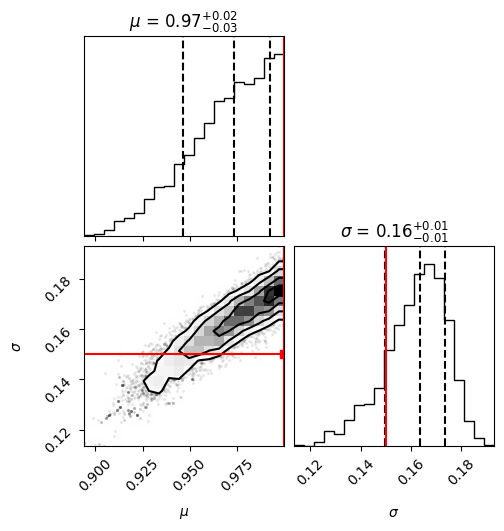

In [16]:
data = np.array([np.array(trace.posterior.mu).flatten(),np.array(trace.posterior.sigma).flatten()]).T
true = np.array([mut, sigmat])
figure = corner.corner(
    data,
    labels=[
        r"$\mu$",
        r"$\sigma$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

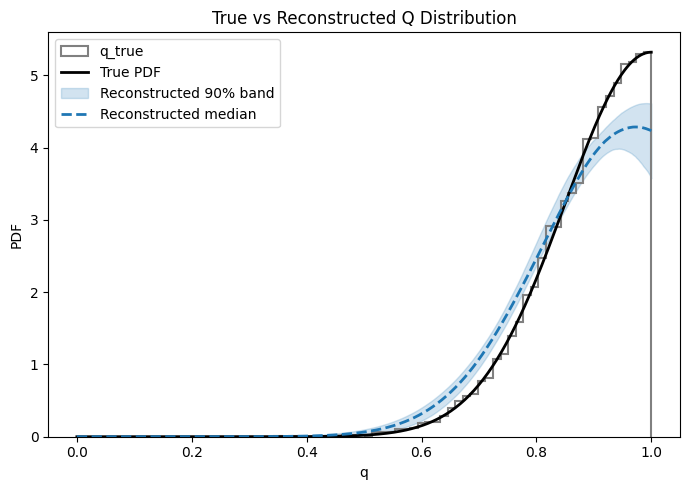

In [17]:
q_grid = np.linspace(0, 1, 500)

at = (0.0 - mut) / sigmat
bt = (1.0 - mut) / sigmat
pdf_true = truncnorm.pdf(q_grid, at, bt, loc=mut, scale=sigmat)

mu_samps = np.array(trace.posterior["mu"]).ravel()
sig_samps = np.array(trace.posterior["sigma"]).ravel()

max_draws = 5000
if mu_samps.size > max_draws:
    idx = np.random.choice(mu_samps.size, max_draws, replace=False)
    mu_samps = mu_samps[idx]
    sig_samps = sig_samps[idx]

a = (0.0 - mu_samps) / sig_samps
b = (1.0 - mu_samps) / sig_samps

pdf_draws = truncnorm.pdf(
    q_grid[None, :],
    a[:, None],
    b[:, None],
    loc=mu_samps[:, None],
    scale=sig_samps[:, None],
)

pdf_med = np.quantile(pdf_draws, 0.50, axis=0)
pdf_lo90 = np.quantile(pdf_draws, 0.05, axis=0)
pdf_hi90 = np.quantile(pdf_draws, 0.95, axis=0)


plt.figure(figsize=(7, 5))
plt.hist(q_true, bins=50, density=True, histtype="step", linewidth=1.5, color="0.5", label="q_true")
plt.plot(q_grid, pdf_true, color="k", lw=2, label="True PDF")

plt.fill_between(q_grid, pdf_lo90, pdf_hi90, color="C0", alpha=0.20, label="Reconstructed 90% band")

plt.plot(q_grid, pdf_med, color="C0", lw=2, linestyle="--", label="Reconstructed median")

plt.xlabel("q")
plt.ylabel("PDF")
plt.title("True vs Reconstructed Q Distribution")
plt.legend()
plt.tight_layout()
plt.show()